<a href="https://colab.research.google.com/github/terryspitz/ipython_notebooks/blob/master/fonttools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888
from enum import Enum, IntEnum
import math
import os
import glob
import xml.etree.ElementTree as ET
import numpy as np
import tensorflow as tf
from PIL import Image, ImageDraw, ImageChops
from IPython.display import display
print(np.__version__)
print(tf.__version__)
np.set_printoptions(precision=2)
import matplotlib.pyplot as plt

#!pip install triangle
import triangle as tr

#!pip install fonttools
#from fontTools.ttLib import TTFont

# should be:
#!pip install ttfquery
# or 
#!conda install -c mwcraig ttfquery
# but actually had to:
#git clone git@github.com:mindw/ttfquery.git
#cd ttfquery
#python setup.py install

import ttfquery.describe
import ttfquery.glyph
import ttfquery.findsystem

#!pip install shapely
# or on windows:
#!conda config --add channels conda-forge
#!conda install shapely
import shapely.ops
import shapely.geometry
import shapely.affinity

#!pip install descartes
import descartes

C:\Users\terry\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.14.2
1.10.0


In [0]:
def readFonts(files: [str], glyphs: str): # type: List(List[MultiPolygon))
  print('loading {} files'.format(len(files)))
  tolerance = 0.001
  fonts = []
  for fontfile in files:
    font = ttfquery.describe.openFont(fontfile)
    multipolys = []
    for glyph in glyphs:
      g = ttfquery.glyph.Glyph(glyph)
      g.compile(font)
      contours = [shapely.geometry.LinearRing(contour) for contour in g.outlines]
      #contours = [shapely.geometry.LinearRing(contour) for contourflags in g.calculateContours(font) for contour, flag in contourflags]
      size = 1.0
      contours = [shapely.affinity.scale(contour, size/g.height, size/g.height, origin=(0,0.1))
                  for contour in contours]
      polys = []
      holes = []
      # Find contours inside other contours and make them holes
      for contour in contours:
        for i, poly in enumerate(polys):
          if shapely.geometry.Polygon(contour).contains(shapely.geometry.Polygon(poly)):
            #replace
            polys[i] = contour
            holes[i].append(poly)
            break
          elif shapely.geometry.Polygon(poly).contains(shapely.geometry.Polygon(contour)):
            holes[i].append(contour)
            break
        else:
          polys.append(contour)
          holes.append([])
      multipolys.append(shapely.geometry.MultiPolygon(
          [shapely.geometry.Polygon(poly, hole).simplify(tolerance) for poly, hole in zip(polys, holes)]))
    fonts.append(multipolys)
  return fonts

In [39]:
print('setup...')
glyphs = [chr(i) for i in range(ord('A'), ord('Z')+1)]
glyphs += [chr(i) for i in range(ord('a'), ord('z')+1)]
glyphs += ['zero','one','two','three','four','five','six','seven','eight','nine']
#glyphs = ['A','B','a','b','one','two']
#glyphs = ['one','two','one','two']
#glyphs = ['A'] + glyphs
glyphs = ['A','B','i','g','eight']
#glyphs = ['A']
max_outline_points = 200
files = glob.glob('deeper/fonts/*.ttf')
files = list(ttfquery.findsystem.findFonts())[2:5]
print(files)
fonts = readFonts(files, glyphs)
#print(fonts[0][0])
#drawOutlines(vertices, segments, )

setup...
['c:\\windows\\fonts\\arialbd.ttf', 'c:\\windows\\fonts\\arialbi.ttf', 'c:\\windows\\fonts\\ariali.ttf']
loading 3 files


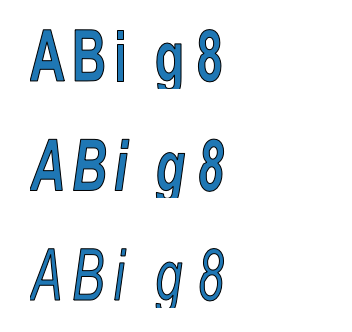

In [40]:
def drawMultiPolygons(polygons):
  fonts = len(polygons)
  glyphs = max([len(polygon) for polygon in polygons])
  plt.figure(figsize=(glyphs,fonts*2))
  for font in range(fonts):
    ax = plt.subplot(fonts+1, 1, 1+font)
    ax.set_xlim(0, glyphs+1)
    ax.set_axis_off()
    for glyph in range(glyphs):
      ax.add_patch(descartes.PolygonPatch(
          shapely.affinity.translate(polygons[font][glyph], glyph*0.8)
      ))
  plt.tight_layout()
  plt.show()

drawMultiPolygons(fonts)


In [0]:
# Shapely triangulation doesn't handle holes
#triangles = shapely.ops.triangulate(fonts[0][0])

def add_multiline(coords, vertices, segments):
  start = len(vertices)
  vertices += coords[:]
  segments += [(i, i+1) for i in range(start, start+len(coords)-1)]
  segments.append((start+len(coords)-1, start))
  
vertices = []
segments = []
holes = []

for glyph in fonts[0][1:2]:
  for poly in glyph:
    add_multiline(poly.exterior.coords, vertices, segments)
    for interior in poly.interiors:
      add_multiline(interior.coords, vertices, segments)
      holes.append(shapely.geometry.Polygon(interior).representative_point().coords[:])
      
  # remove dup points, now using .simplify above
  #   v = np.array(vertices)
  #   print(v.shape)
  #   print(np.all(v == np.roll(v, 1, axis=0), axis=1))
  #   v=v[~np.all(v == np.roll(v, 1, axis=0), axis=1)]
  #   print(v.shape)
  T = {
    'vertices': np.array(vertices),
    'segments': np.array(segments),
    'holes': np.array(holes).reshape((-1,2)),
    }

  # A = tr.get_data('A')
  # del A['vertex_attributes']
  # A['vertices'] = A['vertices'] + np.array([0, 1])
  # A['holes'] = A['holes'] + np.array([0, 1])
  # for k in A.keys():
  #   print(A[k].shape, T[k].shape)
  #   print(A[k][:5])
  #   print(T[k][:5])
  #tr.compare(plt, A, T)
  
  tr.compare(plt, T, T)

  #ax = plt.subplot(121)
  #tr.plot(ax, vertices=vertices, segments=segments)
  print(T.keys())
  tris = tr.triangulate(T, opts='p')
  print(tris.keys())
  tr.compare(plt, T, tris)

  #ax = plt.subplot(122)
  #tr.plot(ax, **tris)
  plt.tight_layout()

  #plt.figure(figsize=(50,2))
  # tr.plot(ax,
  #         vertices=[p for poly in triangles for p in poly.exterior.coords],
  #         triangles=[(i, i+1, i+2) for i in range(len(triangles))]
  #        )
  # for i,poly in enumerate(triangles):
  #   ax = plt.subplot(1, len(triangles), 1+i)
  #   ax.add_patch(descartes.PolygonPatch(poly))
  plt.show()

(75, 2)
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
(75, 2)


In [0]:
#def outlinesToTriStack(vertices, segments, ):
for font in range(1):
  for glyph in range(1):
    tris = tr.triangulate({"vertices": vertices[font, glyph], "segments": segments[font, glyph]}, opts='p')
#     for k,v in tris.items():
#       print(k, v.shape)
#     counts = dict(zip(*np.unique(segments, return_counts=True)))
#     stack = np.full((len(glyphs), max_outline_points, 3), -1, np.int32)
#     triangles = tris["triangles"]
#     new_vertices = tris["vertices"]
#     for t in range(tris["triangles"].shape[0]):
#       stack[t, 0] = new_vertices[triangles[t, 0], 0]
#       stack[t, 1] = new_vertices[triangles[t, 0], 1]
#       stack[t, 2] = (triangles==triangles[t, 0]).sum()



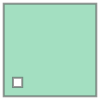

False
True


In [0]:
# debugging shapely contains()
g1=shapely.geometry.LinearRing([(0, 0), (10, 0), (10, 10), (0,10)])
g2=shapely.geometry.LinearRing([(1,1),(2,1),(2,2),(1,2)])
display(shapely.geometry.Polygon(g1, [g2]))
print(g2.within(g1))  # ==False: see https://github.com/Toblerity/Shapely/issues/275
print(shapely.geometry.Polygon(g2).within(shapely.geometry.Polygon(g1))) # ==True

[(array([ 0.2 , -0.79]), array([ 0.2 , -0.78])), (array([ 0.2 , -0.78]), array([ 0.22, -0.77])), (array([ 0.22, -0.77]), array([ 0.25, -0.76])), (array([ 0.25, -0.76]), array([ 0.28, -0.7 ])), (array([ 0.28, -0.7 ]), array([ 0.49, -0.21])), (array([ 0.49, -0.21]), array([ 0.5 , -0.21])), (array([ 0.5 , -0.21]), array([ 0.74, -0.74])), (array([ 0.74, -0.74]), array([ 0.76, -0.76])), (array([ 0.76, -0.76]), array([ 0.77, -0.77])), (array([ 0.77, -0.77]), array([ 0.8 , -0.78])), (array([ 0.8 , -0.78]), array([ 0.8 , -0.79])), (array([ 0.8 , -0.79]), array([ 0.58, -0.79])), (array([ 0.58, -0.79]), array([ 0.58, -0.78])), (array([ 0.58, -0.78]), array([ 0.62, -0.77])), (array([ 0.62, -0.77]), array([ 0.63, -0.76])), (array([ 0.63, -0.76]), array([ 0.64, -0.74])), (array([ 0.64, -0.74]), array([ 0.62, -0.68])), (array([ 0.62, -0.68]), array([ 0.59, -0.6 ])), (array([ 0.59, -0.6 ]), array([ 0.36, -0.6 ])), (array([ 0.36, -0.6 ]), array([ 0.32, -0.71])), (array([ 0.32, -0.71]), array([ 0.31, -

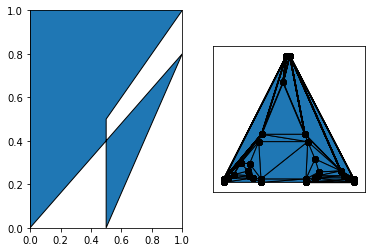

In [0]:
#points = shapely.geometry.MultiPoint([(0, 0), (1, 1), (0, 2), (2, 2), (3, 1), (1, 0)])
print([(A["vertices"][s], A["vertices"][e]) for s,e in A["segments"]])
points = shapely.geometry.MultiPoint([A["vertices"][s] for s,e in A["segments"]])
triangles = shapely.ops.triangulate(points)
print([triangle.wkt for triangle in triangles])

ax1 = plt.subplot(122)
tr.plot(ax1,
        vertices=[p for poly in triangles for p in poly.exterior.coords],
        triangles=[(i, i+1, i+2) for i in range(len(triangles))]
       )
for poly in triangles:
  ax1.add_patch(descartes.PolygonPatch(poly))
# plt.show()

#fig = plt.figure(1, figsize=(5,5), dpi=90)
ring_mixed = shapely.geometry.Polygon([(0, 0), (0, 1.8), (1, 1), (.5, .5), (.5, 0), (1, 0.8), (0, 0)])
#ax = fig.add_subplot(111)
ax = plt.subplot(121)
ax.add_patch(descartes.PolygonPatch(ring_mixed))

plt.show()

dict_keys(['vertices', 'segments', 'holes'])


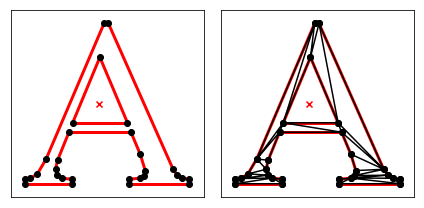

In [0]:
# Sample from https://rufat.be/triangle/API.html

#A = dict(vertices=np.array(((0, 0), (1, 0), (1, 1), (0, 1))))
A = tr.get_data('A')
del A['vertex_attributes']
print(A.keys())
B = tr.triangulate(A, opts='p')
tr.compare(plt, A, B)
# #plt.figure()
# ax1 = plt.subplot(121)
# tr.plot(ax1, **A)
# lim = ax1.axis()
# ax2 = plt.subplot(122, sharey=ax1)
# tr.plot(ax2, **B)
# ax2.axis(lim)
# plt.tight_layout()
plt.show()